In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
import os

In [3]:
# Load data
print(os.listdir(os.curdir))
x_train = pd.read_csv('train.csv')
x_test = pd.read_csv('test.csv')
y_test = pd.read_csv('gender_submission.csv')

['.ipynb_checkpoints', 'ANOVA.ipynb', 'Experimental setup in AB testing.ipynb', 'gender_submission.csv', 'test.csv', 'titanic.ipynb', 'train.csv']


### Exploration

In [4]:
x_train.info()
x_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026716AF1198>]],
      dtype=object)

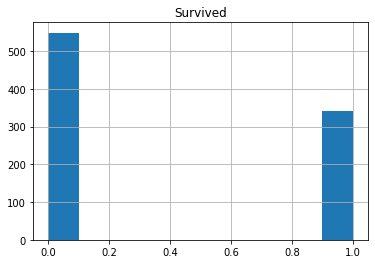

In [5]:
# Data exploration with some histogram: is there a correlation between the Survived col and the others?

x_train.hist('Survived')
# there are more dead than survived passengers

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026716DDA5C0>,
      dtype=object)

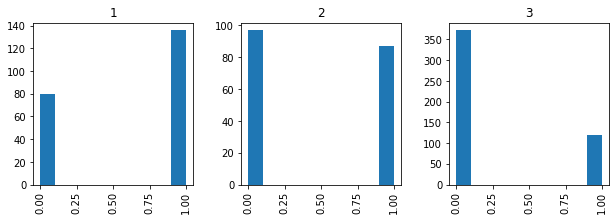

In [6]:
x_train.hist('Survived', by='Pclass', layout=[1, 3], figsize=[10, 3])
# by = group by the column; layout = how to dispose the plots; figsize= resize the plots (usually to fit them better on one line or column)
# The higher the class, the higher the probability of survive
# The second class passengers are almost evenly distributed

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026716DDA7B8>,
      dtype=object)

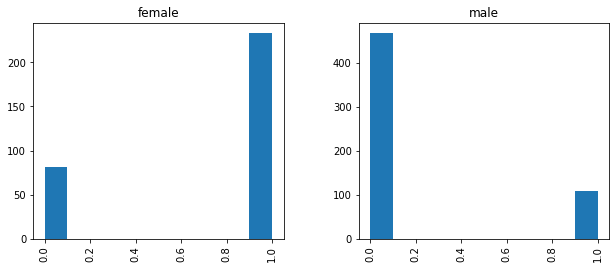

In [7]:
x_train.hist('Survived', by='Sex', layout=[1, 2], figsize=[10, 4])
# Being a woman would have enhanced your chances to survive the disaster

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000267170A1358>,
      dtype=object)

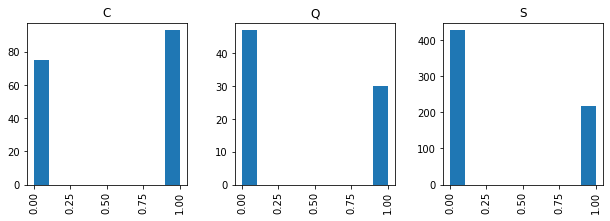

In [8]:
x_train.hist('Survived', by='Embarked', layout=[1, 3], figsize=[10, 3])
# If you embarked in the port of Cherbourg you had higher chances to live.
# Maybe the port is correlated with the passenger's class?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026717153198>,
      dtype=object)

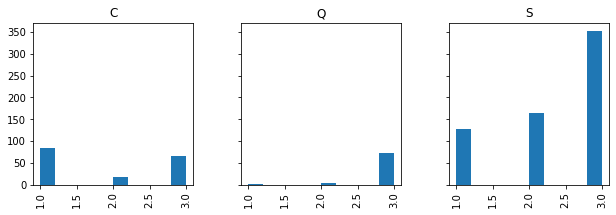

In [9]:
x_train.hist('Pclass', by='Embarked', layout=[1, 3], figsize=[10, 3],
             sharey=True)
# a correlation could be spotted, but should be further investigated.
# we can assert that almost half of the passengers embarked in C had a first
# class ticket, even if the majority of them embarked in S.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000267174A8860>,
      dtype=object)

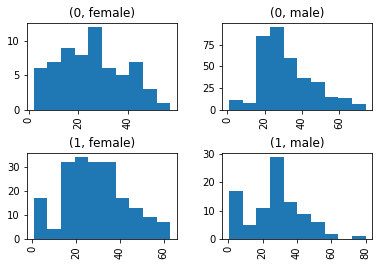

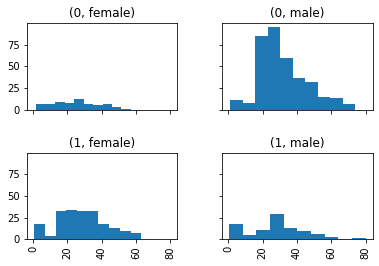

In [10]:
# Histogram of Age grouped by Survived and Sex, bins=step to divide the Age variables into
x_train.hist('Age', bins=10, by=['Survived', 'Sex'])
x_train.hist('Age', bins=10, by=['Survived', 'Sex'],
             sharex=True, sharey=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002671779A780>,
      dtype=object)

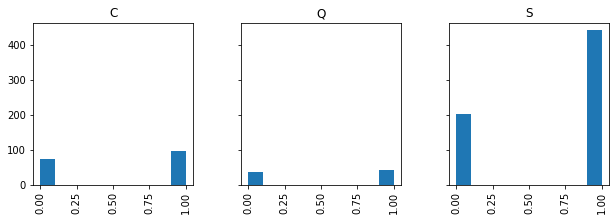

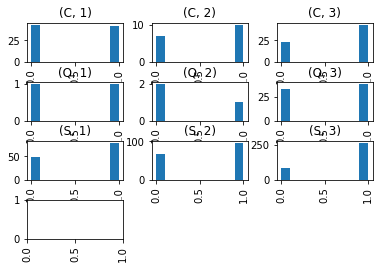

In [11]:
# Embarked vs sex
# get_dummies does one-hot-encoding. drop_first avoid the creation of a correlated column
is_male = pd.get_dummies(x_train['Sex'], drop_first=True)
x_train['is_male'] = is_male
x_train.hist('is_male', by='Embarked', layout=[1, 3], figsize=[10, 3],
             sharey=True)

x_train.hist('is_male', by=['Embarked', 'Pclass'])


In [12]:
# Missing values analysis
x_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
is_male          0
dtype: int64

In [13]:
# we are going to impute all those missing data points with the median Age.
# But since we have the Title of every passenger, we infer their Age 'Title' group wise  
# expand serves to return always a DataFrame
x_train['title'] = x_train['Name'].str.lower().str.extract('([a-z]*\.)', expand=True)

In [14]:
# Some examples
missing_age = dict()
missing_age['dr.'] = x_train[((x_train['Age'].isnull()==True) & (x_train['title']=='dr.'))].index.tolist()
missing_age['mister.'] = x_train[((x_train['Age'].isnull()==True) & (x_train['title']=='mister.'))].index.tolist()
missing_age['miss.'] = x_train[((x_train['Age'].isnull()==True) & (x_train['title']=='miss.'))].index.tolist()
missing_age['mr.'] = x_train[((x_train['Age'].isnull()==True) & (x_train['title']=='mr.'))].index.tolist()
missing_age['mrs.'] = x_train[((x_train['Age'].isnull()==True) & (x_train['title']=='mrs.'))].index.tolist()

for k, v in missing_age.items():
    if v:
        missing_age[k] = v[0]
    else:
        missing_age[k] = None

In [15]:
is_missing_age_pid = [False for _ in range(x_train.shape[0])]
for j in missing_age.values(): 
    if j: 
        is_missing_age_pid[j] = True
x_train[is_missing_age_pid]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_male,title
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,mr.
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0,mrs.
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,0,miss.
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6000,NaN,C,1,dr.


In [16]:
# remember that a sentence must be included in brackets to be considered valid by pandas.
# i.e.  df[A & B] KO
#       df[(A) & (B)] OK
# df[<condition>] works like the `which` function in R. It allows to select only the data points 
# that respect the condition in the square brackets
avg_dr = x_train[((x_train['title'] == 'dr.') & (x_train['Age'].isnull() == False))]['Age'].median()
avg_master = x_train[((x_train['title'] == 'master.') & (x_train['Age'].isnull() == False))]['Age'].median()
avg_miss = x_train[((x_train['title'] == 'miss.') & (x_train['Age'].isnull() == False))]['Age'].median()
avg_mr = x_train[((x_train['title'] == 'mr.') & (x_train['Age'].isnull() == False))]['Age'].median()
avg_mrs = x_train[((x_train['title'] == 'mrs.') & (x_train['Age'].isnull() == False))]['Age'].median()

In [17]:
# Now to replace the missing values. We can do it with a for loop or with a single command.
# Let's use the df.loc function. 
# df[condition] export the data points only for visualization purposes; to modify them we use df.loc
# The syntax is df.loc[<row condition>, <column condition>]
# the column condition can be just the name of the column as a string
# the .tolist() method transform a dataframe into a list. maybe unnecessary
x_train.loc[((x_train['title'] == 'dr.') & (x_train['Age'].isnull()==True)).tolist(), 'Age'] = avg_dr
x_train.loc[((x_train['title'] == 'master.') & (x_train['Age'].isnull()==True)).tolist(), 'Age'] = avg_master
x_train.loc[((x_train['title'] == 'miss.') & (x_train['Age'].isnull()==True)).tolist(), 'Age'] = avg_miss
x_train.loc[((x_train['title'] == 'mr.') & (x_train['Age'].isnull()==True)).tolist(), 'Age'] = avg_mr
x_train.loc[((x_train['title'] == 'mrs.') & (x_train['Age'].isnull()==True)).tolist(), 'Age'] = avg_mrs

In [18]:
x_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
is_male          0
title            0
dtype: int64

In [19]:
# apparently pandas wants a list of booleans of the same dimension of the df to select specific rows
x_train.loc[is_missing_age_pid]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_male,title
5,6,0,3,"Moran, Mr. James",male,30.0,0,0,330877,8.4583,NaN,Q,1,mr.
19,20,1,3,"Masselmani, Mrs. Fatima",female,35.0,0,0,2649,7.2250,NaN,C,0,mrs.
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,21.0,0,0,330959,7.8792,NaN,Q,0,miss.
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,46.5,0,0,112379,39.6000,NaN,C,1,dr.


## Hypothesis Testing

### Student's t-test
Statistical hypothesis test in which the test statistic follows a Student's t-distribution under the null hypothesis.
(see https://en.wikipedia.org/wiki/Student%27s_t-test for details)

Two of the most common uses are:

1. A *one-sample* location test of whether **the mean has a value specified** in the null hp
2. A *two-samples* location test of the null hp such that **the means of two populations are equal**. This works if the variances of the population are also assumed equal. If this assumption is dropped, the Welch t-test can be used.

In [20]:
# We will measure whether the average age of the survived differs from the age of the dead passengers
# First we need to compute the sample variance of the two population (survived vs dead):
x_surv = x_train.loc[x_train['Survived'].tolist()]
x_dead = x_train.loc[(1-x_train['Survived']).tolist()]

In [21]:
x_surv = x_train[x_train['Survived'] == 1]
x_surv.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,is_male
count,342.000000,342.0,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,444.368421,1.0,1.950292,28.066287,0.473684,0.464912,48.395408,0.318713
std,252.358840,0.0,0.863321,14.085381,0.708688,0.771712,66.596998,0.466660
min,2.000000,1.0,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,250.750000,1.0,1.000000,21.000000,0.000000,0.000000,12.475000,0.000000
50%,439.500000,1.0,2.000000,28.000000,0.000000,0.000000,26.000000,0.000000
75%,651.500000,1.0,3.000000,35.000000,1.000000,1.000000,57.000000,1.000000
max,890.000000,1.0,3.000000,80.000000,4.000000,5.000000,512.329200,1.000000


In [22]:
x_dead = x_train[x_train['Survived'] == 0]
x_dead.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,is_male
count,549.000000,549.0,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,447.016393,0.0,2.531876,30.214936,0.553734,0.329690,22.117887,0.852459
std,260.640469,0.0,0.735805,12.671138,1.288399,0.823166,31.388207,0.354968
min,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,211.000000,0.0,2.000000,22.000000,0.000000,0.000000,7.854200,1.000000
50%,455.000000,0.0,3.000000,30.000000,0.000000,0.000000,10.500000,1.000000
75%,675.000000,0.0,3.000000,35.000000,1.000000,0.000000,26.000000,1.000000
max,891.000000,0.0,3.000000,74.000000,8.000000,6.000000,263.000000,1.000000


In [23]:
{'var_surv': x_surv['Age'].var(), 'var_dead': x_dead['Age'].var()}

{'var_surv': 198.39795244550766, 'var_dead': 160.55773270578203}

In [24]:
# The two population do not have the same variance, 
# but we will try both the tests (same sample variance and different sample variance)

In [25]:
# Standard independent 2-sample test: the population variances are assumed equal
# H0: mu_surv = mu_dead vs H1: mu_surv <> mu_dead
statistic, pvalue = stats.ttest_ind(x_surv['Age'].array, x_dead['Age'].array)
pvalue

0.018623643214940117

The *pvalue* is **the probability of obtaining results as extreme as the observed result of a statistical hypothesis test, assuming the null hypothesis is true**.
The statistical hp test is built using the population (i.e. its population average and variance).

For example the statistical hypothesis Student's t-test is: $$Y_{0} = \frac{\bar{X}-\mu_{0}}{s/\sqrt n}$$ where:

- $\bar{X}$ is the population mean
- $\mu_{0}$ is the null hypothesis value to be tested
- $s$ is the population standard deviation
- $n$ is the number of samples

The pvalue is $$P(Y \geq Y_{0}|H_{0})$$

Seeing everything from a stat hp test perspective, we can reformulate $H_{0}$ as the hypothesis that $Y_{0}$ or a more extreme value can be drawn from $Y$.

BUT

$$P(observation|hypothesis) \neq P(hypothesis|observation)$$, 

thus using the pvalue as a score is committing a logical error: the *tranposed condition fallacy*
It is not true to assert that if the probability of an observation under a hp is low, than the probability that given the observation the hp is true is low. The two numbers can be very different.

In our case, we are estimating the probability that the H0: $\mu_{surv}=\mu_{dead}$ is valid given the data with the probability that, given the null hp, we should draw a result as extreme as the one from the statistical hp test.
Since this value is far away from the center of the distribution, the probability of drawing it (pvalue) is low.

Thus there is statistical evidence to reject the null hypothesis.

In [26]:
# Welch 2-sample test: the population variances are different
# equal_var = False
# H0: mu_surv = mu_dead vs H1: mu_surv <> mu_dead
statistic, pvalue = stats.ttest_ind(x_surv['Age'].array, x_dead['Age'].array, equal_var=False)
pvalue

0.021744814090944902

In [27]:
# Still pretty low.
# If we had a known variance and a normal distribution, we could have used the z-test.
# If the variance is unknown, the Student's t-test shall be used.

### Chi-squared test

The chi-square test tests the null hypothesis that **the categorical data has the given frequencies**.

In [28]:
# Table of frequencies
crosstab = pd.crosstab(x_train['Survived'], [x_train['Sex'], x_train['Pclass']])
crosstab

Sex      female         male         
Pclass        1   2   3    1   2    3
Survived                             
0             3   6  72   77  91  300
1            91  70  72   45  17   47

In [29]:
# Let's test that the proportion of survived males is independent from the passenger's class
crosstab = pd.crosstab(x_train['Survived'][x_train['Sex']=='male'], [x_train['Pclass'][x_train['Sex']=='male']])
crosstab_males = crosstab.to_numpy()[1]
crosstab_males

array([45, 17, 47], dtype=int64)

In [30]:
# expected frequency
f_exp = [int(sum(crosstab_males)/3) for j in crosstab_males]
f_exp[0] = int(f_exp[0]) + 1
f_exp = np.array(f_exp).astype(np.int64)
f_exp

array([37, 36, 36], dtype=int64)

In [31]:
from scipy.stats import chisquare
chisquare([45, 17, 47], f_exp=f_exp)
# chisquare(crosstab_males, f_exp=f_exp)

Power_divergenceResult(statistic=15.118618618618619, pvalue=0.0005212351318382975)

In [32]:
# Power_divergence is probably a module bug
# H0 rejected. Let's try another one based on crosstab: females survived vs males survived
crosstab_surv = pd.crosstab(x_train['Sex'][x_train['Survived']==1], [x_train['Pclass'][x_train['Survived']==1]])
crosstab_surv

Pclass,1,2,3
Sex,,,
female,91,70,72
male,45,17,47


In [33]:
crosstab_surv.astype(np.int64)
chisquare(crosstab_surv.to_numpy()[0,], crosstab_surv.to_numpy()[1,])

Power_divergenceResult(statistic=225.55538868029484, pvalue=1.0501943229903619e-49)

In [1]:
# Even lower! No statistical evidence to accept H0. Qui esce power divergence perchè sta provando un altro test, in cui
# la somma delle frequenze è diversa tra le popolazioni. Se fossero identiche mi farebbe correttamente chisquare

## Two-samples *t*-test for Equal Means

The two-sample t-test is used to determine if two population means are equal. A common application is to test if a new process or treatment is superior to a current process or treatment. The two population have different distribution.

There are several variations on this test.

1. The data may either be paired or not paired. By paired, we mean that there is a one-to-one correspondence between the values in the two samples. That is, if $X_1,X_2,\dots,X_n$ and $Y_1,Y_2,\dots,Y_n$ are the two samples, then $X_i$ corresponds to $Y_i$. For paired samples, the difference $X_i - Y_i$ is usually calculated. For unpaired samples, the sample sizes for the two samples may or may not be equal. The formulas for paired data are somewhat simpler than the formulas for unpaired data.
2. The variances of the two samples may be assumed to be equal or unequal. Equal variances yields somewhat simpler formulas, although with computers this is no longer a significant issue.
3. In some applications, you may want to adopt a new process or treatment only if it exceeds the current treatment by some threshold. In this case, we can state the null hypothesis in the form that the difference between the two populations means is equal to some constant $\mu_1−\mu_2=d_0$ where the constant is the desired threshold.

The **two-sample t-test** for unpaired data is defined as:
$$H_0:	\mu_1=\mu_2$$
$$H_a:	\mu_1\neq\mu_2$$


Test Statistic:	$T=\frac{Y_1−Y_2}{\sqrt{s^2_1/N_1+s^2_2/N_2}}$

where $N_1$ and $N_2$ are the sample sizes, $Y_1$ and $Y_2$ are the sample means, and $s^2_1$ and $s^2_2$ are the sample variances.

If equal variances are assumed, then the formula reduces to: $T=\frac{Y_1−Y_2}{s_{p}\sqrt{1/N_1+1/N_2}}$

where $s^2_p=\frac{(N_1−1)s^2_1+(N_2−1)s^2_2}{N_1+N_2−2}$

Significance Level: $\alpha$.

Critical Region: Reject the null hypothesis that the two means are equal if $|T| > t_{1-\alpha/2$,ν}$

where $t_{1-α/2,ν}$ is the **critical value** of the **t distribution** with ν degrees of freedom where
$$ν=\frac{(s^2_1/N_1+s^2_2/N_2)^2}{(s^2_1/N_1)^2/(N_1−1)+(s^2_2/N_2)^2/(N_2−1)}$$

If equal variances are assumed, then $$ν = N_1 + N_2 - 2$$

## Confidence Intervals

--Theory for confidence intervals--

Before diving in, keep in mind that the *mean of the population* (the thing we what to estimate) is a constant, there is no randomness about the number.

The confidence interval is an estimator we use to estimate the value of population parameters. The interval will create a range that might contain the values. When we create the interval, we use a sample mean. Recall the central limit theorem, if we sample many times, the sample mean will be normally distributed.

This proposes a range of plausible values for an unknown parameter (for example, the mean). The interval has an associated confidence level that the true parameter is in the proposed range. Given observations $x_{1},\ldots ,x_{n}$ and a confidence level $\gamma$ , a valid confidence interval has a $\gamma$  probability of containing the true underlying parameter. 

For the Student's t-distribution the interval whose endpoints are
$$\overline {X}_{n}\pm A{\frac {S_{n}}{\sqrt {n}}}$$
is a 90% confidence interval for $\mu$, where $A$ is the "95th percentile" of this probability distribution, or $A=t_{(0.05,n-1)}$

Three ways to get them with the `scipy` module:
1. `st.t.interval` correct also for small n
2. `statsmodel.stats.api.DescrStatsW` correct also for small n
3. `st.norm.interval` correct only in case of a normal distributed sample or n>30 (for large sample size the sample mean is normally distributed)

## Prediction Intervals

A prediction interval is a range that is likely to contain the response value of a single new observation given specified settings of the predictors in your model.

## ANOVA

--Theory for confidence intervals--

Before diving in, keep in mind that the *mean of the population* (the thing we what to estimate) is a constant, there is no randomness about the number.

The confidence interval is an estimator we use to estimate the value of population parameters. The interval will create a range that might contain the values. When we create the interval, we use a sample mean. Recall the central limit theorem, if we sample many times, the sample mean will be normally distributed.

This proposes a range of plausible values for an unknown parameter (for example, the mean). The interval has an associated confidence level that the true parameter is in the proposed range. Given observations $x_{1},\ldots ,x_{n}$ and a confidence level $\gamma$ , a valid confidence interval has a $\gamma$  probability of containing the true underlying parameter. 

For the Student's t-distribution the interval whose endpoints are
$$\overline {X}_{n}\pm A{\frac {S_{n}}{\sqrt {n}}}$$
is a 90% confidence interval for $\mu$, where $A$ is the "95th percentile" of this probability distribution, or $A=t_{(0.05,n-1)}$

Three ways to get them with the `scipy` module:
1. `st.t.interval` correct also for small n
2. `statsmodel.stats.api.DescrStatsW` correct also for small n
3. `st.norm.interval` correct only in case of a normal distributed sample or n>30 (for large sample size the sample mean is normally distributed)

## Prediction Intervals

A prediction interval is a range that is likely to contain the response value of a single new observation given specified settings of the predictors in your model.

## ANOVA

--Theory for confidence intervals--

Before diving in, keep in mind that the *mean of the population* (the thing we what to estimate) is a constant, there is no randomness about the number.

The confidence interval is an estimator we use to estimate the value of population parameters. The interval will create a range that might contain the values. When we create the interval, we use a sample mean. Recall the central limit theorem, if we sample many times, the sample mean will be normally distributed.

This proposes a range of plausible values for an unknown parameter (for example, the mean). The interval has an associated confidence level that the true parameter is in the proposed range. Given observations $x_{1},\ldots ,x_{n}$ and a confidence level $\gamma$ , a valid confidence interval has a $\gamma$  probability of containing the true underlying parameter. 

For the Student's t-distribution the interval whose endpoints are
$$\overline {X}_{n}\pm A{\frac {S_{n}}{\sqrt {n}}}$$
is a 90% confidence interval for $\mu$, where $A$ is the "95th percentile" of this probability distribution, or $A=t_{(0.05,n-1)}$

Three ways to get them with the `scipy` module:
1. `st.t.interval` correct also for small n
2. `statsmodel.stats.api.DescrStatsW` correct also for small n
3. `st.norm.interval` correct only in case of a normal distributed sample or n>30 (for large sample size the sample mean is normally distributed)

## Prediction Intervals

A prediction interval is a range that is likely to contain the response value of a single new observation given specified settings of the predictors in your model.

## ANOVA

--Theory for confidence intervals--

Before diving in, keep in mind that the *mean of the population* (the thing we what to estimate) is a constant, there is no randomness about the number.

The confidence interval is an estimator we use to estimate the value of population parameters. The interval will create a range that might contain the values. When we create the interval, we use a sample mean. Recall the central limit theorem, if we sample many times, the sample mean will be normally distributed.

This proposes a range of plausible values for an unknown parameter (for example, the mean). The interval has an associated confidence level that the true parameter is in the proposed range. Given observations $x_{1},\ldots ,x_{n}$ and a confidence level $\gamma$ , a valid confidence interval has a $\gamma$  probability of containing the true underlying parameter. 

For the Student's t-distribution the interval whose endpoints are
$$\overline {X}_{n}\pm A{\frac {S_{n}}{\sqrt {n}}}$$
is a 90% confidence interval for $\mu$, where $A$ is the "95th percentile" of this probability distribution, or $A=t_{(0.05,n-1)}$

Three ways to get them with the `scipy` module:
1. `st.t.interval` correct also for small n
2. `statsmodel.stats.api.DescrStatsW` correct also for small n
3. `st.norm.interval` correct only in case of a normal distributed sample or n>30 (for large sample size the sample mean is normally distributed)

## Prediction Intervals

A prediction interval is a range that is likely to contain the response value of a single new observation given specified settings of the predictors in your model.

## ANOVA

--Theory for confidence intervals--

Before diving in, keep in mind that the *mean of the population* (the thing we what to estimate) is a constant, there is no randomness about the number.

The confidence interval is an estimator we use to estimate the value of population parameters. The interval will create a range that might contain the values. When we create the interval, we use a sample mean. Recall the central limit theorem, if we sample many times, the sample mean will be normally distributed.

This proposes a range of plausible values for an unknown parameter (for example, the mean). The interval has an associated confidence level that the true parameter is in the proposed range. Given observations $x_{1},\ldots ,x_{n}$ and a confidence level $\gamma$ , a valid confidence interval has a $\gamma$  probability of containing the true underlying parameter. 

For the Student's t-distribution the interval whose endpoints are
$$\overline {X}_{n}\pm A{\frac {S_{n}}{\sqrt {n}}}$$
is a 90% confidence interval for $\mu$, where $A$ is the "95th percentile" of this probability distribution, or $A=t_{(0.05,n-1)}$

Three ways to get them with the `scipy` module:
1. `st.t.interval` correct also for small n
2. `statsmodel.stats.api.DescrStatsW` correct also for small n
3. `st.norm.interval` correct only in case of a normal distributed sample or n>30 (for large sample size the sample mean is normally distributed)

## Prediction Intervals

A prediction interval is a range that is likely to contain the response value of a single new observation given specified settings of the predictors in your model.

## ANOVA

In [39]:
males = x_train[x_train['Sex']=='male']['Age']
females = x_train[x_train['Sex']=='female']['Age']
stats.f_oneway(males, females)

F_onewayResult(statistic=9.876212856246399, pvalue=0.0017297768346056126)

The pvalue is low: there is stastical significance to reject the null hypothesis that the males and females on the Titanic had the same average age.

Let's do the same (one-way anova) with the survival variable

In [42]:
surv = x_train[x_train['Survived']==1]['Age']
dead = x_train[x_train['Survived']==0]['Age']
stats.f_oneway(surv, dead)

F_onewayResult(statistic=5.556922786236765, pvalue=0.018623643214932786)

The pvalue here is bigger but not big enough to accept the null hypothesis.

From the graphs above we should find two populations with the same mean...

In [45]:
# Since we are lazy, we create two population with a very similar mean and test them
np.random.seed(123)
x1 = np.random.normal(loc=0, scale=1, size=1000)
x2 = np.random.normal(loc=0.0001, scale=1, size=500)
stats.f_oneway(x1, x2)

F_onewayResult(statistic=3.4651655206187297, pvalue=0.06286997109557806)

Finally! The two samples share the same mean.

### Logistic Regression

In [79]:
# I want to try to draw a ROC Curve, so I need a logistic regression
x_lr = x_train.loc[:,['Fare']]
y_lr = x_train.Survived

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [132]:
model = LogisticRegression(solver='lbfgs')
model.fit(x_lr, y_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [133]:
model.classes_

array([0, 1], dtype=int64)

In [126]:
y_hat = model.predict_proba(x_lr)[:,1] # probability of Survival
y_pred = model.predict(x_lr)

In [131]:
model.predict_proba(x_lr)[0], y_pred[0], y_lr[0]
model.predict_proba(x_lr)

array([[0.69659638, 0.30340362],
       [0.46457191, 0.53542809],
       [0.69442404, 0.30557596],
       ...,
       [0.64220704, 0.35779296],
       [0.61902646, 0.38097354],
       [0.69498808, 0.30501192]])

In [122]:
print(classification_report(y_lr, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.93      0.77       549
           1       0.68      0.24      0.35       342

    accuracy                           0.67       891
   macro avg       0.67      0.59      0.56       891
weighted avg       0.67      0.67      0.61       891



In [123]:
print(confusion_matrix(y_lr, y_pred))

[[511  38]
 [260  82]]


In [124]:
fpr, tpr, _ = roc_curve(y_lr, y_hat)
roc_auc = roc_auc_score(y_lr, y_hat)

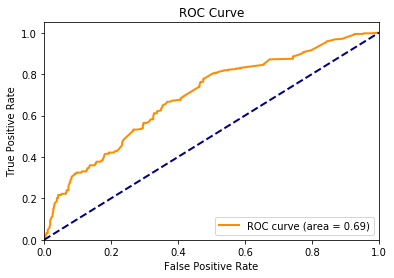

In [134]:
# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### References:
1. pandas https://www.kaggle.com/inturiyam/exploring-titanic-data-using-pandas-dataframes/data
2. confidence intervals https://towardsdatascience.com/illustration-with-python-confidence-interval-ee4736cc3dc2
3. chi-squared and why n-1 dof https://it.wikipedia.org/wiki/Test_chi_quadrato
4. ROC Curve in Python https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html